In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yf

 **Download S&P 500 data**

In [ ]:
sp500 = yf.download("^GSPC", start="1980-01-01", end="2024-01-01")

C:\Users\Ruvarashe\AppData\Local\Temp\ipykernel_39872\2889866643.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start="1980-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


In [6]:
# Check what columns exist
print(sp500.columns)

MultiIndex([( 'Close', '^GSPC'),
            (  'High', '^GSPC'),
            (   'Low', '^GSPC'),
            (  'Open', '^GSPC'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])


**Select the 'Close' column for ticker ^GSPC**

In [ ]:
sp500_series = sp500["Close"]["^GSPC"]

**Resample to annual average**

In [ ]:
sp500_annual = sp500_series.resample("Y").mean().reset_index()
sp500_annual["Year"] = sp500_annual["Date"].dt.year
sp500_annual = sp500_annual.rename(columns={sp500_annual.columns[1]: "SP500"})

C:\Users\Ruvarashe\AppData\Local\Temp\ipykernel_39872\1077354477.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  sp500_annual = sp500_series.resample("Y").mean().reset_index()


**Regression: SP500 ~ Year**

In [ ]:
X = sm.add_constant(sp500_annual["Year"])
y = sp500_annual["SP500"]
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  SP500   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     165.7
Date:                Thu, 02 Oct 2025   Prob (F-statistic):           3.62e-16
Time:                        13:18:49   Log-Likelihood:                -336.04
No. Observations:                  44   AIC:                             676.1
Df Residuals:                      42   BIC:                             679.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.558e+05   1.22e+04    -12.767      0.0

### Key Statistics

Dependent Variable: SP500 (annual level, 1980–2023)

R² = 0.798 → The model explains ~80% of the variation in the S&P 500 levels.

Year coefficient (β = 78.49, p < 0.001) → Each additional year adds, on average, about 78 points to the S&P 500 index.

Constant = –155,800 → Nonsensical in financial terms (the model predicts negative values far in the past).

F-statistic highly significant (p < 0.001) → Regression overall is statistically significant.

Durbin-Watson = 0.168 → Very low, showing strong serial correlation in residuals (a red flag in time series).

Condition Number = 315,000 → Indicates non-stationarity and possible multicollinearity with the time trend.

the S&P 500 has trended upward since 1980, so the regression produces a positive and significant slope.
But in reality, this model is misleading:

Spurious Regression Problem → Both Year and SP500 are non-stationary, trending variables. A regression between two trending series will almost always show a high R² and significant t-stats, even if there is no real causal link (Granger & Newbold, 1974).

Economic Implausibility → The idea that the index rises by a fixed ~78 points every year is unrealistic. Market growth is multiplicative (compounded returns), not linear with calendar time.

Serial Correlation → Durbin-Watson near 0 confirms that errors are autocorrelated, violating OLS assumptions.

### **Proposed Resolution**

1. Transform Data (Stationarity)

2.  Convert index levels into returns (log or percent changes). Returns are typically stationary.

3. Regression of returns on Year should yield no significant trend (as expected).

**Alternative Models**

4. ARIMA models can capture autocorrelation and volatility clustering.

5. Factor models (e.g., CAPM, Fama-French) explain returns based on economic variables, not just time.

6. If interest is long-run equilibrium, use cointegration analysis instead of raw OLS.

The regression shows a strong fit, but it is spurious. The high R² and significant slope arise from both variables trending upward, not from an economic relationship. In financial econometrics, levels of stock indices must be transformed into returns before meaningful regression analysis.

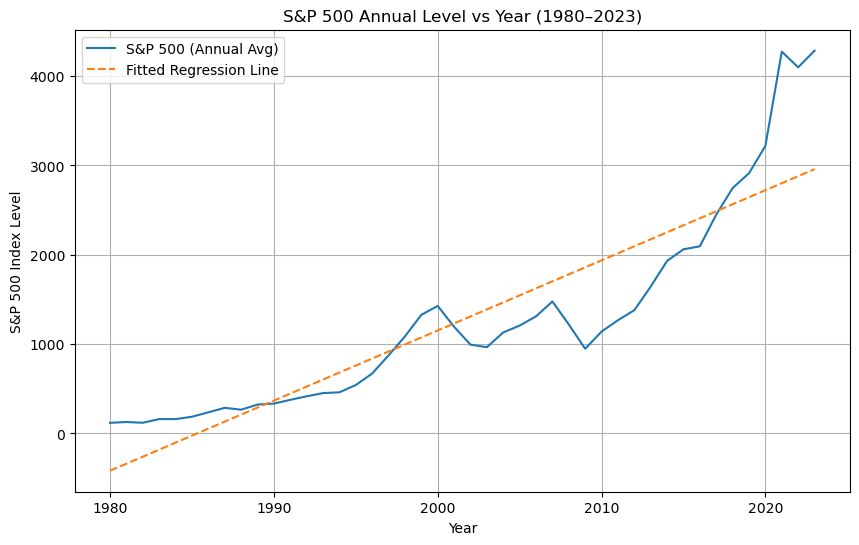

In [10]:
# Plot
plt.figure(figsize=(10,6))
plt.plot(sp500_annual["Year"], sp500_annual["SP500"], label="S&P 500 (Annual Avg)")
plt.plot(sp500_annual["Year"], model.predict(X), linestyle="--", label="Fitted Regression Line")
plt.title("S&P 500 Annual Level vs Year (1980–2023)")
plt.xlabel("Year")
plt.ylabel("S&P 500 Index Level")
plt.legend()
plt.grid(True)
plt.show()

Blue Line (S&P 500 Annual Avg): Actual index values show exponential-like growth, with sharp upward movements (e.g., 1990s dot-com boom, post-2009 recovery, 2020–2021 surge).

Orange Dashed Line (OLS Fit): The regression line is linear, rising steadily at ~78 points per year.

**Why This Is Misleading**

The fitted line underestimates recent explosive growth and overestimates early values (predicts negative S&P 500 in the early 1980s).

Despite a high R² = 0.798, the model does not capture the true market dynamics.

This mismatch reflects the spurious regression problem: both variables (Year and Index Level) trend upwards, producing an artificial relationship.

**Resolution**

Transform Data into Returns:
Instead of regressing levels on Year, compute annual returns

Returns are stationary, so regressing them on Year will likely yield no significant trend — the correct result.

Use Time Series Models (ARIMA/GARCH): Returns exhibit autocorrelation and volatility clustering; ARIMA or GARCH models are better suited.

For Long-Run Analysis: If the question is about growth trends, use log-transformed levels and check for cointegration with macroeconomic fundamentals (GDP, inflation, rates).